In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2class - cigarette / vape

In [7]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_2 (Conv2D)           (None, 56, 56, 128)          8320      ['max_pooling2d[0][0]']   

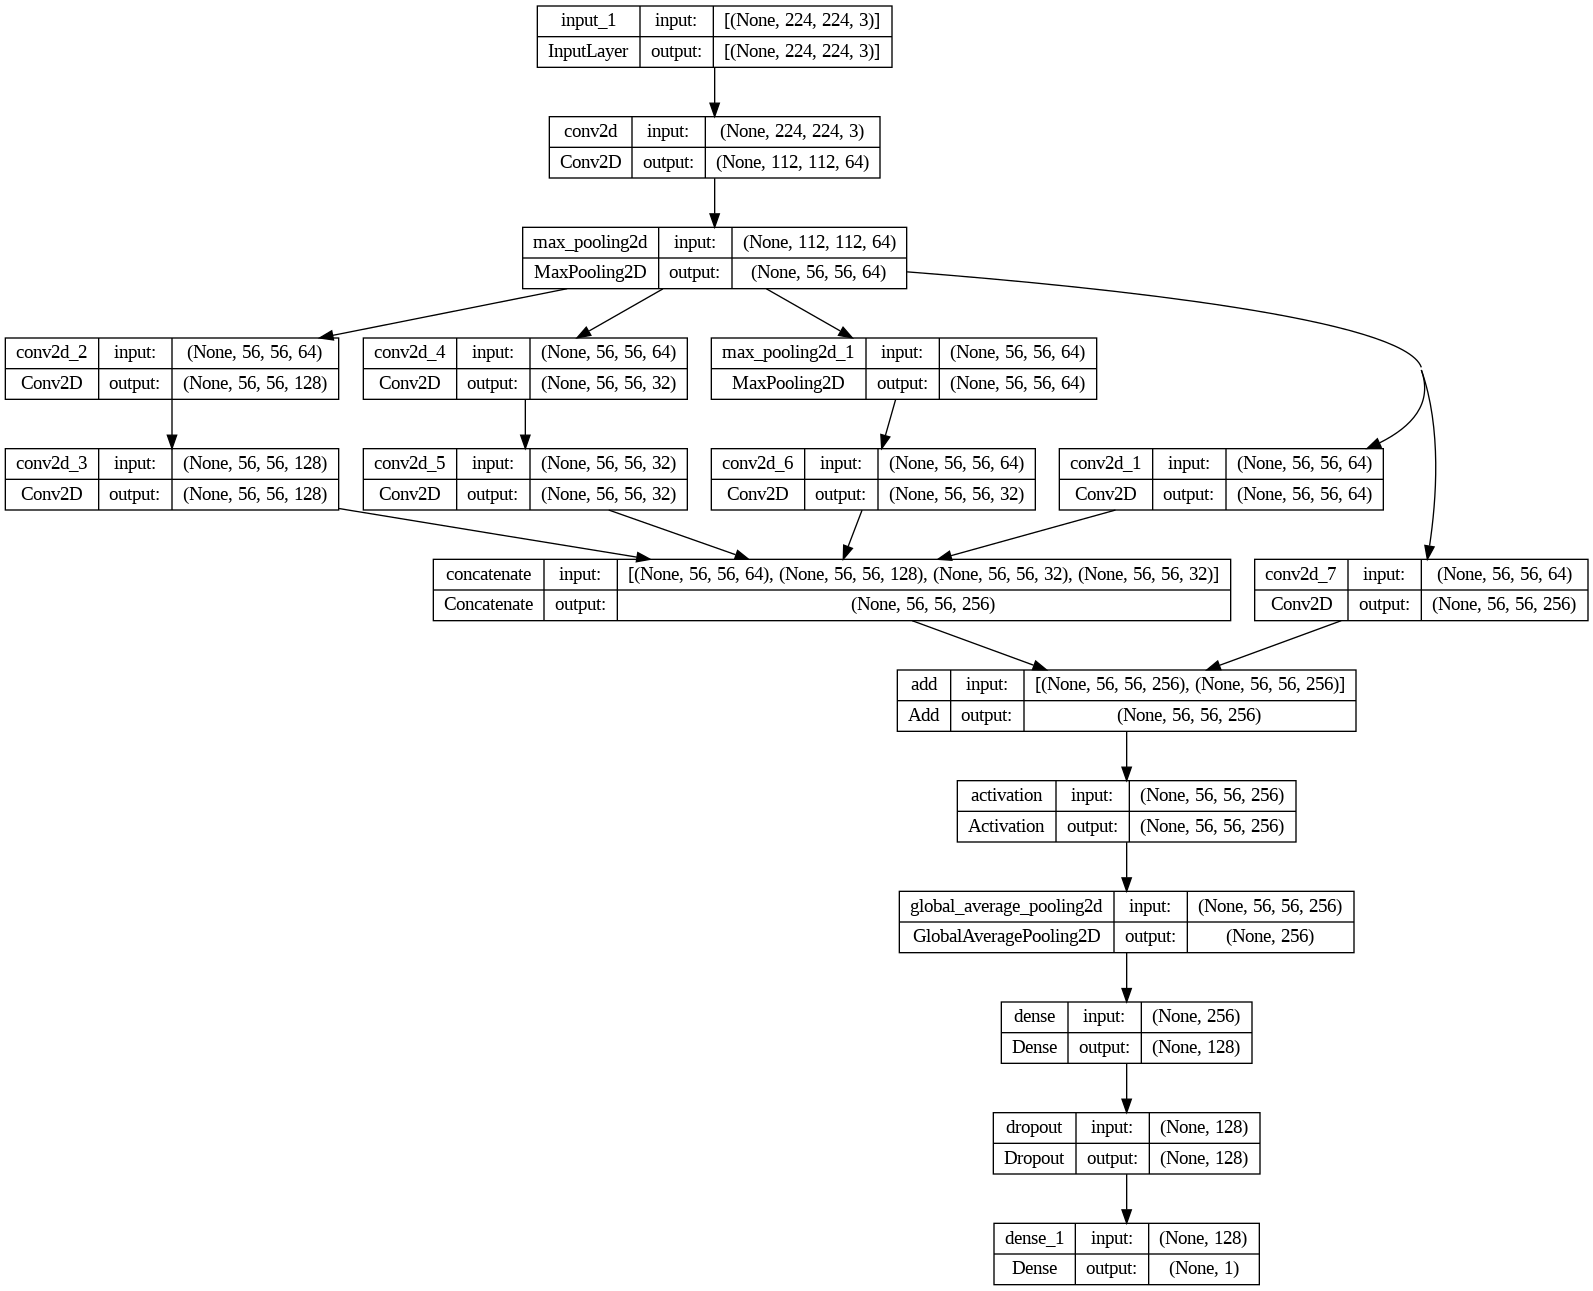

In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

def inception_module(x, filters):
    # 1x1 convolution
    conv1 = layers.Conv2D(filters=filters[0], kernel_size=(1,1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv3 = layers.Conv2D(filters=filters[1], kernel_size=(1,1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='relu')(conv3)

    # 5x5 convolution
    conv5 = layers.Conv2D(filters=filters[2], kernel_size=(1,1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(filters=filters[2], kernel_size=(5,5), padding='same', activation='relu')(conv5)

    # 3x3 max pooling
    pool = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
    pool = layers.Conv2D(filters=filters[3], kernel_size=(1,1), padding='same', activation='relu')(pool)

    # Concatenate all filters
    output = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)

    return output

def resnet_inception_block(x, filters):
    # Inception module
    inception = inception_module(x, filters)

    # Skip connection
    skip = layers.Conv2D(filters=inception.shape[-1], kernel_size=(1,1), padding='same')(x)

    output = layers.add([inception, skip])
    output = layers.Activation('relu')(output)

    return output

def create_resnet_inception_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

    # Example: Stack of 1 ResNet-Inception block
    filters = [64, 128, 32, 32]
    x = resnet_inception_block(x, filters)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    return model

# 모델 생성
input_shape = (224, 224, 3)  # 예시 입력 크기
model = create_resnet_inception_model(input_shape)

# 모델 요약 출력
model.summary()

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# 모델 구조를 이미지로 저장
plot_model(model, to_file='hybrid_model(InceptionNet + ResNet).png', show_shapes=True, show_layer_names=True)


In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=5,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)
#***경로 변경***
model_name = 'hybrid_model(InceptionNet + ResNet50V2)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                          monitor='val_loss',
                          save_best_only=True)

# 모델 학습
history = model.fit(train_generator, epochs=30, validation_data=valid_generator, callbacks = [checkpoint,early_stopping])

Epoch 1/30
376/376 [==============================] - 3951s 10s/step - loss: 0.6812 - accuracy: 0.5751 - val_loss: 0.6788 - val_accuracy: 0.5978
Epoch 2/30
376/376 [==============================] - 85s 227ms/step - loss: 0.6377 - accuracy: 0.6521 - val_loss: 0.6481 - val_accuracy: 0.6099
Epoch 3/30
376/376 [==============================] - 84s 223ms/step - loss: 0.6007 - accuracy: 0.6801 - val_loss: 0.6284 - val_accuracy: 0.6090
Epoch 4/30
376/376 [==============================] - 85s 226ms/step - loss: 0.5712 - accuracy: 0.7088 - val_loss: 0.6102 - val_accuracy: 0.6401
Epoch 5/30
376/376 [==============================] - 82s 218ms/step - loss: 0.5477 - accuracy: 0.7337 - val_loss: 0.6392 - val_accuracy: 0.6202
Epoch 6/30
376/376 [==============================] - 81s 214ms/step - loss: 0.5388 - accuracy: 0.7413 - val_loss: 0.6111 - val_accuracy: 0.6471
Epoch 7/30
376/376 [==============================] - 83s 219ms/step - loss: 0.5277 - accuracy: 0.7516 - val_loss: 0.6117 - val_ac

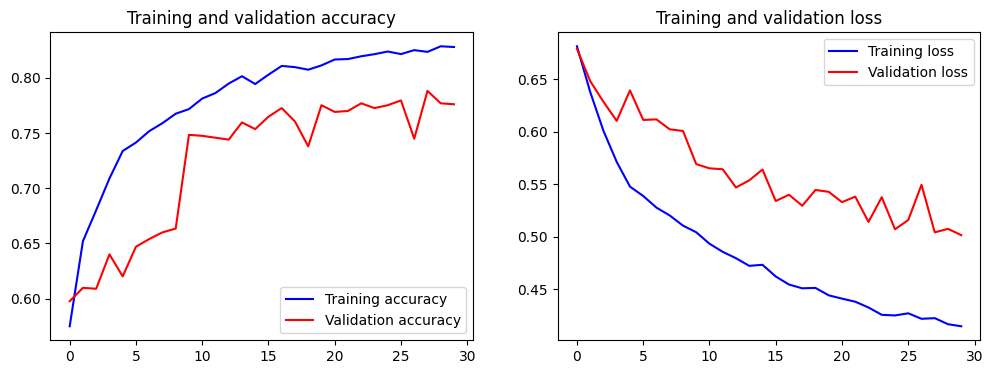

18/18 [==============================] - 3s 169ms/step - loss: 0.4986 - accuracy: 0.7487
Test Accuracy: 0.7486631274223328
18/18 [==============================] - 4s 199ms/step


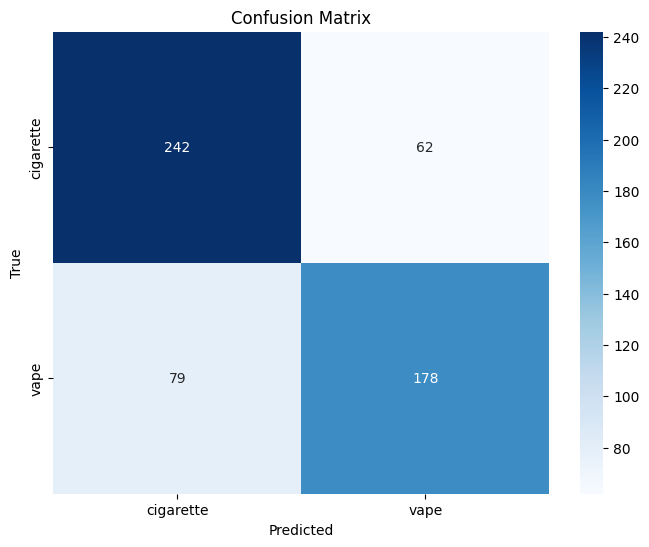

              precision    recall  f1-score   support

   cigarette       0.75      0.80      0.77       304
        vape       0.74      0.69      0.72       257

    accuracy                           0.75       561
   macro avg       0.75      0.74      0.75       561
weighted avg       0.75      0.75      0.75       561



In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # 임계값 0.5로 이진화

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)


{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}
18/18 [==============================] - 4s 202ms/step


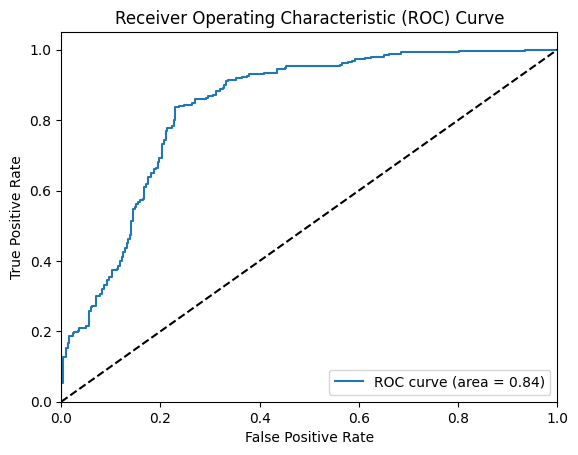

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 클래스 인덱스 확인
class_indices = test_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(test_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#추가 학습 - 30 epoch 더

In [12]:
# 모델 학습
extra_model = model
extra_history = extra_model.fit(train_generator, epochs=30, validation_data=valid_generator, callbacks = [checkpoint,early_stopping])

Epoch 1/30
376/376 [==============================] - 95s 252ms/step - loss: 0.4112 - accuracy: 0.8313 - val_loss: 0.5055 - val_accuracy: 0.7863
Epoch 2/30
376/376 [==============================] - 86s 227ms/step - loss: 0.4015 - accuracy: 0.8353 - val_loss: 0.4966 - val_accuracy: 0.7664
Epoch 3/30
376/376 [==============================] - 92s 245ms/step - loss: 0.4051 - accuracy: 0.8345 - val_loss: 0.4921 - val_accuracy: 0.7777
Epoch 4/30
376/376 [==============================] - 82s 219ms/step - loss: 0.4060 - accuracy: 0.8324 - val_loss: 0.5024 - val_accuracy: 0.7699
Epoch 5/30
376/376 [==============================] - 82s 219ms/step - loss: 0.4000 - accuracy: 0.8330 - val_loss: 0.5205 - val_accuracy: 0.7638
Epoch 6/30
376/376 [==============================] - 85s 226ms/step - loss: 0.3931 - accuracy: 0.8397 - val_loss: 0.5013 - val_accuracy: 0.7612
Epoch 7/30
376/376 [==============================] - 83s 221ms/step - loss: 0.3971 - accuracy: 0.8377 - val_loss: 0.4948 - val_ac

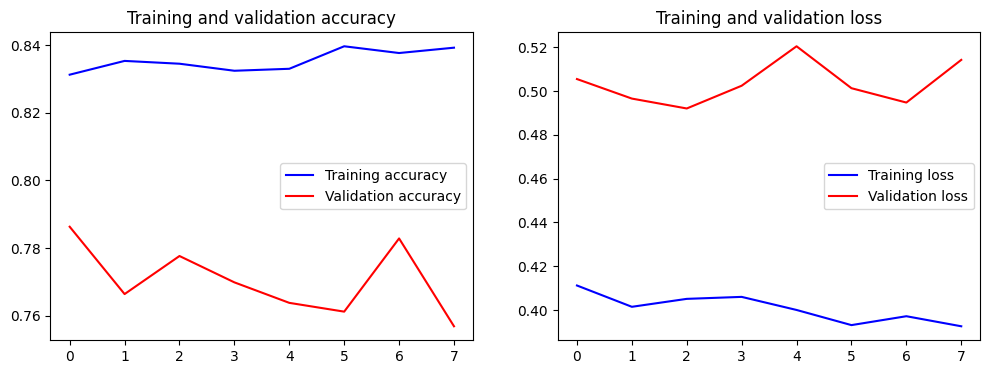

18/18 [==============================] - 4s 199ms/step - loss: 0.4992 - accuracy: 0.7558
Test Accuracy: 0.7557932138442993
18/18 [==============================] - 3s 185ms/step


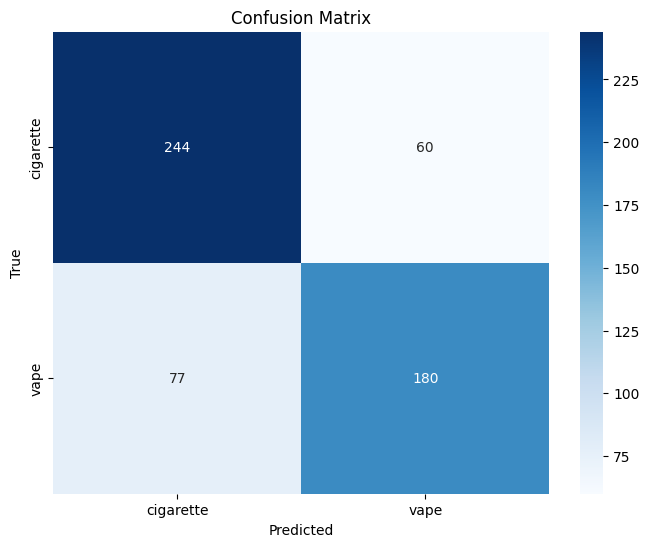

              precision    recall  f1-score   support

   cigarette       0.76      0.80      0.78       304
        vape       0.75      0.70      0.72       257

    accuracy                           0.76       561
   macro avg       0.76      0.75      0.75       561
weighted avg       0.76      0.76      0.75       561

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}
18/18 [==============================] - 4s 198ms/step


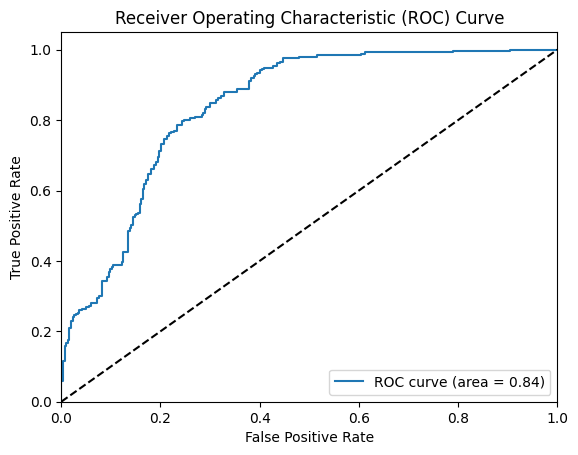

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 학습 결과 시각화
acc = extra_history.history['accuracy']
val_acc = extra_history.history['val_accuracy']
loss = extra_history.history['loss']
val_loss = extra_history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = extra_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = extra_model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # 임계값 0.5로 이진화

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

# 클래스 인덱스 확인
class_indices = test_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(test_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#학습률이 너무 높은가...0.00001로 낮춰서 30 epoch 더 돌려보기

In [15]:
learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

extra_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
extra_history = extra_model.fit(train_generator, epochs=30, validation_data=valid_generator, callbacks = [checkpoint,early_stopping])

Epoch 1/30
376/376 [==============================] - 94s 242ms/step - loss: 0.3901 - accuracy: 0.8421 - val_loss: 0.4910 - val_accuracy: 0.7889
Epoch 2/30
376/376 [==============================] - 88s 233ms/step - loss: 0.3870 - accuracy: 0.8424 - val_loss: 0.4887 - val_accuracy: 0.7855
Epoch 3/30
376/376 [==============================] - 84s 224ms/step - loss: 0.3858 - accuracy: 0.8441 - val_loss: 0.4877 - val_accuracy: 0.7881
Epoch 4/30
376/376 [==============================] - 83s 220ms/step - loss: 0.3835 - accuracy: 0.8456 - val_loss: 0.4892 - val_accuracy: 0.7881
Epoch 5/30
376/376 [==============================] - 83s 221ms/step - loss: 0.3823 - accuracy: 0.8470 - val_loss: 0.4904 - val_accuracy: 0.7872
Epoch 6/30
376/376 [==============================] - 89s 236ms/step - loss: 0.3835 - accuracy: 0.8460 - val_loss: 0.4899 - val_accuracy: 0.7855
Epoch 7/30
376/376 [==============================] - 82s 218ms/step - loss: 0.3846 - accuracy: 0.8436 - val_loss: 0.4915 - val_ac

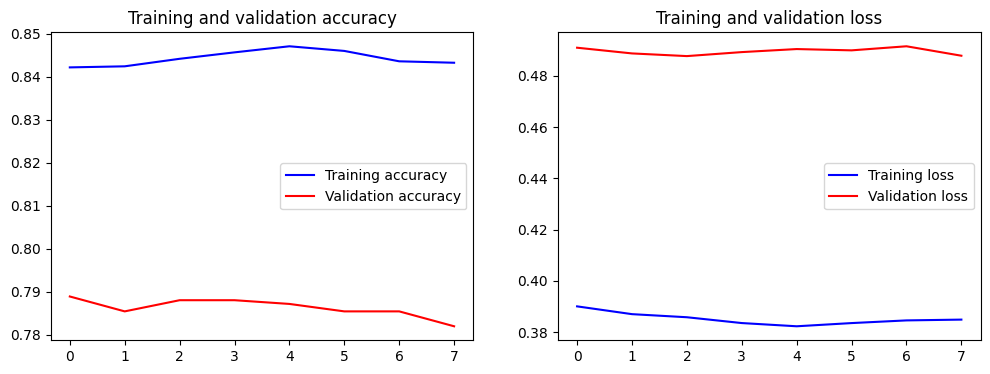

18/18 [==============================] - 3s 168ms/step - loss: 0.4880 - accuracy: 0.7629
Test Accuracy: 0.7629233598709106
18/18 [==============================] - 3s 167ms/step


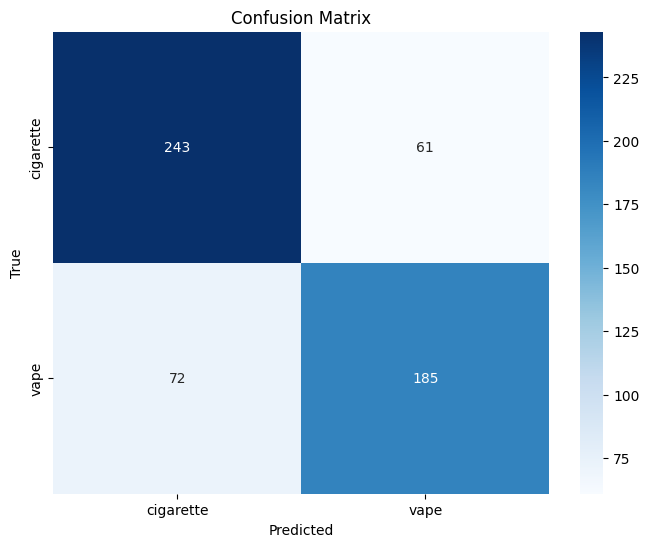

              precision    recall  f1-score   support

   cigarette       0.77      0.80      0.79       304
        vape       0.75      0.72      0.74       257

    accuracy                           0.76       561
   macro avg       0.76      0.76      0.76       561
weighted avg       0.76      0.76      0.76       561

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}
18/18 [==============================] - 4s 197ms/step


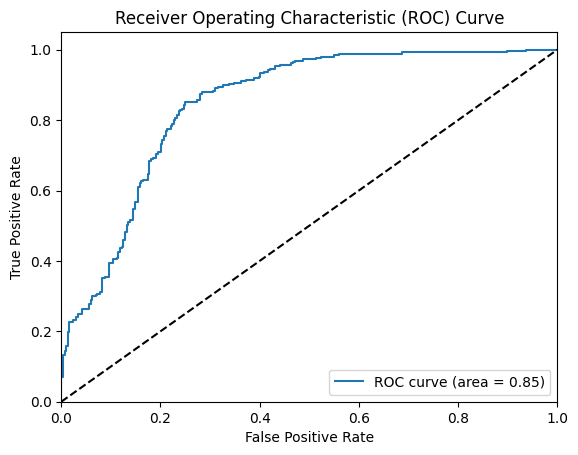

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 학습 결과 시각화
acc = extra_history.history['accuracy']
val_acc = extra_history.history['val_accuracy']
loss = extra_history.history['loss']
val_loss = extra_history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = extra_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = extra_model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # 임계값 0.5로 이진화

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

# 클래스 인덱스 확인
class_indices = test_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(test_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()